# Box Office Analysis

authors: Greg Fatouras and Evan Rosenbaum

# Business Problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Sources of Data 

- Box Office Mojo
    - CSV
    - https://www.boxofficemojo.com/
- IMDB
    - DB
    - https://www.imdb.com/
- Rotten Tomatoes
    - TSVs
    - https://www.rottentomatoes.com/
- The Movie DB
    - CSV
    - https://www.themoviedb.org/
- The Numbers
    - CSV
    - https://www.the-numbers.com/

In [464]:
# Import packages
import sqlite3
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# IMDB extraction

In [465]:
# Extract db from zipped file
zip_path = 'zippedData/im.db.zip'
extract_dir = 'zippedData'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [466]:
# Connect to SQLite3
conn = sqlite3.connect('zippedData/im.db') 
cursor = conn.cursor()

# View tables query
tables_query = """
SELECT *
FROM sqlite_master
WHERE type='table'
"""

pd.read_sql(tables_query, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [467]:
# List each table
table_names = [
    'movie_basics'
    ,'directors'
    ,'known_for'
    ,'movie_akas'
    ,'movie_ratings'
    ,'persons'
    ,'principals'
    ,'writers'
]

# Extract the columns from each table in the database
for table in table_names:
    headers_query = f"SELECT * FROM {table}"
    df = pd.read_sql(headers_query, conn)
    print(f"\nHeader for {table}:")
    print(df.columns.to_list())



Header for movie_basics:
['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']

Header for directors:
['movie_id', 'person_id']

Header for known_for:
['person_id', 'movie_id']

Header for movie_akas:
['movie_id', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'is_original_title']

Header for movie_ratings:
['movie_id', 'averagerating', 'numvotes']

Header for persons:
['person_id', 'primary_name', 'birth_year', 'death_year', 'primary_profession']

Header for principals:
['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters']

Header for writers:
['movie_id', 'person_id']


In [468]:
imdb_cast_info_query = """

with movie_info AS (
SELECT *
FROM movie_basics
),

cast_info AS (
SELECT
    *
FROM principals
INNER JOIN persons
ON principals.person_id = persons.person_id
),

movie_rating AS (
SELECT *
FROM movie_ratings
),

us_movies AS (
SELECT * 
FROM movie_akas
WHERE region = 'US'
AND region IS NOT NULL
)

SELECT
    movie_info.movie_id
    ,primary_title AS title
    ,start_year AS year
    ,COALESCE(CAST(runtime_minutes AS text), 'unknown') AS runtime_minutes
    ,COALESCE(genres, 'unknown') AS genres
    ,category AS cast_category
    ,primary_name AS cast_name
    ,averagerating
    ,numvotes
FROM movie_info
INNER JOIN us_movies 
ON movie_info.movie_id = us_movies.movie_id
INNER JOIN cast_info
ON movie_info.movie_id = cast_info.movie_id
LEFT JOIN movie_rating
ON movie_info.movie_id = movie_rating.movie_id

"""
imdb_cast_info_df = pd.read_sql(imdb_cast_info_query, conn)

In [469]:
imdb_movie_rating_query = """

with movie_info AS (
SELECT *
FROM movie_basics
),

movie_rating AS (
SELECT *
FROM movie_ratings
),

us_movies AS (
SELECT * 
FROM movie_akas
WHERE region = 'US'
)

SELECT
    movie_info.movie_id
    ,primary_title AS title
    ,start_year AS year
    ,COALESCE(CAST(runtime_minutes AS text), 'unknown') AS runtime_minutes
    ,COALESCE(genres, 'unknown') AS genres
    ,averagerating
    ,numvotes
FROM movie_info
INNER JOIN us_movies 
ON movie_info.movie_id = us_movies.movie_id
LEFT JOIN movie_rating
ON movie_info.movie_id = movie_rating.movie_id

"""
imdb_movie_rating_df = pd.read_sql(imdb_movie_rating_query, conn)

# RT, BOM, TMDB, and TN extraction

In [470]:
# Load all other dataframes and view columns
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', encoding='latin1', delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', encoding='latin1', delimiter='\t')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', encoding='utf-8')

dfs = [bom_df ,rt_movie_info_df ,rt_reviews_df ,tmdb_df ,tn_df]
dfs_str = ['bom_df' ,'rt_movie_info_df' ,'rt_reviews_df' ,'tmdb_df' ,'tn_df']

for x in range(len(dfs)):
    print(dfs_str[x])
    print(dfs[x].columns)
    print("\n")

bom_df
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


rt_movie_info_df
Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')


rt_reviews_df
Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date'],
      dtype='object')


tmdb_df
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')


tn_df
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')




### Box Office Mojo Exploration

In [471]:
# View high-level information about the DataFrame
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


#### 'studio'

In [472]:
# View NaNs in the 'studio' column
bom_df[bom_df['studio'].isna()]

,title,studio,domestic_gross,foreign_gross,year
210,Outside the Law (Hors-la-loi),NaN,96900.0,3300000,2010
555,Fireflies in the Garden,NaN,70600.0,3300000,2011
933,Keith Lemon: The Film,NaN,NaN,4000000,2012
1862,Plot for Peace,NaN,7100.0,NaN,2014
2825,Secret Superstar,NaN,NaN,122000000,2017


Overview
    - It isn't clear as to why the studios for these films are not included inside of the BOM csv. 

Action
    - While the information exists for these five films, to maintain consistency with other tables we are going to enter the studio as 'unknown'. 

#### 'domestic_gross' and 'foreign_gross' 

In [473]:
# View NaNs in the 'foreign_gross' column
bom_df[bom_df['foreign_gross'].isna()]

,title,studio,domestic_gross,foreign_gross,year
222,Flipped,WB,1800000.0,NaN,2010
254,The Polar Express (IMAX re-issue 2010),WB,673000.0,NaN,2010
267,Tiny Furniture,IFC,392000.0,NaN,2010
269,Grease (Sing-a-Long re-issue),Par.,366000.0,NaN,2010
280,Last Train Home,Zeit.,288000.0,NaN,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018



- Overview
    - NaN values inside of these column indicate that there was no revenue generated from either a domestic or international release. The movie might have had a subsequent releases either domestic or international post their initial release, but the revenue from that is not captured inside of the row as it occurred in a different year. 

- Example
    - Flipped (2010)
        - https://www.boxofficemojo.com/title/tt0817177/?ref_=bo_se_r_1
        - The films original release had no international revenue generated, but upon further releases in 2017 and 2020 there was.
        - That said, since the revenue was generated in a different year, it is not tied to the record in question. 

- Action
    - Fill the NaN values inside of both the 'domestic_gross' and 'foreign_gross' columns with 0's.

In [474]:
# View transformed DataFrame
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### Rotten Tomatoes Exploration

In [475]:
rt_combined_df = rt_movie_info_df.merge(rt_reviews_df, how='inner', on='id', suffixes=('_info', '_review'))

In [476]:
rt_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             54432 non-null  int64 
 1   synopsis       54300 non-null  object
 2   rating_info    54346 non-null  object
 3   genre          54345 non-null  object
 4   director       48992 non-null  object
 5   writer         45206 non-null  object
 6   theater_date   53206 non-null  object
 7   dvd_date       53206 non-null  object
 8   currency       33310 non-null  object
 9   box_office     33310 non-null  object
 10  runtime        53594 non-null  object
 11  studio         40125 non-null  object
 12  review         48869 non-null  object
 13  rating_review  40915 non-null  object
 14  fresh          54432 non-null  object
 15  critic         51710 non-null  object
 16  top_critic     54432 non-null  int64 
 17  publisher      54123 non-null  object
 18  date           54432 non-n

### The Movie DB Exploration

In [477]:
# View high-level information about the DataFrame
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [478]:
# View DataFrame results
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


- Overview
    - There are no NaN values inside of the DataFrame so no actions are needed to ensure missingness is handled. 

- Notes
    - genre_ids
        - https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
        - We can map the ids to be the specific genres rather than the id (if needed)


### The Numbers Exploration

In [479]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [480]:
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


- Overview
    - There are no NaN values inside of the DataFrame so no actions are needed to ensure missingness is handled. 

### IMDB DB Exploration

In [481]:
# View DataFrame
imdb_cast_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388634 entries, 0 to 388633
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         388634 non-null  object 
 1   title            388634 non-null  object 
 2   year             388634 non-null  int64  
 3   runtime_minutes  388634 non-null  object 
 4   genres           388634 non-null  object 
 5   cast_category    388634 non-null  object 
 6   cast_name        388634 non-null  object 
 7   averagerating    264280 non-null  float64
 8   numvotes         264280 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 26.7+ MB


In [482]:
# View DataFrame
imdb_movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         51490 non-null  object 
 1   title            51490 non-null  object 
 2   year             51490 non-null  int64  
 3   runtime_minutes  51490 non-null  object 
 4   genres           51490 non-null  object 
 5   averagerating    30194 non-null  float64
 6   numvotes         30194 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.7+ MB


# Initial Dataframe lengths

In [483]:
print("IMDB cast info:",'{:>9}'.format(len(imdb_cast_info_df)))
print("IMDB movie rating:",'{:>6}'.format(len(imdb_movie_rating_df)))
print("TN:",'{:>20}'.format(len(tn_df)))
print("TMDB:",'{:>19}'.format(len(tmdb_df)))
print("RT movie info:",'{:>9}'.format(len(rt_movie_info_df)))
print("BOM:",'{:>19}'.format(len(bom_df)))

IMDB cast info:    388634
IMDB movie rating:  51490
TN:                 5782
TMDB:               26517
RT movie info:      1560
BOM:                3387


# Dataframe Cleaning


## bom_df

In [484]:
# Fill NaNs with 'unknown'
bom_df['studio'].fillna('unknown', inplace=True)
# Fill NaNs with 0's
bom_df[['domestic_gross', 'foreign_gross']] = bom_df[['domestic_gross', 'foreign_gross']].fillna(0)

# bom_df : Remove (3D) and years at the end of the title strings
bom_df['title'] = bom_df['title'].str.replace(' \(3D\)', '').str.replace(' \(\d{4}\)', '')

bom_df["title"].value_counts() # One duplicate
bom_df[bom_df["title"] != "Bluebeard"] # Remove bluebeard duplicate
bom_df.isna().value_counts() # No nan's

# > 2000
bom_df = bom_df[bom_df['year'] > 2000]
bom_df

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,0,2018
3383,Edward II (2018 re-release),FM,4800.0,0,2018
3384,El Pacto,Sony,2500.0,0,2018
3385,The Swan,Synergetic,2400.0,0,2018


## TMDB

In [485]:
# Drop duplicate ID's
tmdb_df = tmdb_df.drop_duplicates(subset=['id'])

In [486]:
# Find differing titles
different = tmdb_df['original_title'] != tmdb_df['title']

In [487]:
# Filter the DataFrame 
differences = tmdb_df[different]
# 'Original title' contains foreign language titles
#differences

In [488]:
# Dropping 'original title' becuase it's in the foreign language
tmdb_df = tmdb_df.drop('original_title', axis = 1) 

In [489]:
# Sort by date
tmdb_df = tmdb_df.sort_values(by = 'release_date', ascending = False)

In [490]:
# Adding year, month, day, and day of week
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], format="%Y-%m-%d")

In [491]:
# Adding genre codes
tmdb_codes = [
    {"id": 28, "genre": "Action", "type": "MOVIE"},
    {"id": 12, "genre": "Adventure", "type": "MOVIE"},
    {"id": 16, "genre": "Animation", "type": "MOVIE"},
    {"id": 35, "genre": "Comedy", "type": "MOVIE"},
    {"id": 80, "genre": "Crime", "type": "MOVIE"},
    {"id": 99, "genre": "Documentary", "type": "MOVIE"},
    {"id": 18, "genre": "Drama", "type": "MOVIE"},
    {"id": 10751, "genre": "Family", "type": "MOVIE"},
    {"id": 14, "genre": "Fantasy", "type": "MOVIE"},
    {"id": 36, "genre": "History", "type": "MOVIE"},
    {"id": 27, "genre": "Horror", "type": "MOVIE"},
    {"id": 10402, "genre": "Music", "type": "MOVIE"},
    {"id": 9648, "genre": "Mystery", "type": "MOVIE"},
    {"id": 10749, "genre": "Romance", "type": "MOVIE"},
    {"id": 878, "genre": "Science Fiction", "type": "MOVIE"},
    {"id": 10770, "genre": "TV Movie", "type": "MOVIE"},
    {"id": 53, "genre": "Thriller", "type": "MOVIE"},
    {"id": 10752, "genre": "War", "type": "MOVIE"},
    {"id": 37, "genre": "Western", "type": "MOVIE"}

]

In [492]:
# Taking the first genre if multible genres are listed

tmdb_df = tmdb_df[tmdb_df["genre_ids"] != "[]"]

genre = []

for temp in tmdb_df['genre_ids']:
    temp = temp.strip()
    temp = temp.lstrip('[')
    temp = temp.split(']')[0]

    genre.append(temp.split(',')[0])

tmdb_df['genre_ids'] = genre

# Creating movie/show, genere columns
genre_str = []

for item in tmdb_df['genre_ids']:

    for value in tmdb_codes:

        if item == str(value['id']):
            genre_str.append(value['genre'])
            break
        
tmdb_df['genre_str'] = genre_str
len(genre_str)




23036

In [493]:
# Extract month, day, and year
tmdb_df['month'] = tmdb_df['release_date'].dt.month
tmdb_df['day'] = tmdb_df['release_date'].dt.day
tmdb_df['year'] = tmdb_df['release_date'].dt.year
tmdb_df['day_of_week'] = tmdb_df['release_date'].dt.day_name()

# Everything after 2000
tmdb_df = tmdb_df[tmdb_df['year'] > 2000]
tmdb_df 

,Unnamed: 0,genre_ids,id,original_language,popularity,release_date,title,vote_average,vote_count,genre_str,month,day,year,day_of_week
26057,26057,27,570704,en,0.840,2020-12-25,Murdery Christmas,0.0,1,Horror,12,25,2020,Friday
24265,24265,10749,428836,en,8.715,2019-06-28,Ophelia,0.0,4,Romance,6,28,2019,Friday
24892,24892,99,541577,en,3.955,2019-06-28,This Changes Everything,0.0,1,Documentary,6,28,2019,Friday
24297,24297,18,415085,en,8.316,2019-05-17,All Creatures Here Below,5.0,5,Drama,5,17,2019,Friday
24819,24819,18,481880,en,4.480,2019-05-17,Trial by Fire,7.0,3,Drama,5,17,2019,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24082,24082,28,11299,ja,11.761,2002-08-11,Cowboy Bebop: The Movie,7.7,311,Action,8,11,2002,Sunday
5311,5311,80,9573,en,9.839,2002-08-06,Blood Work,6.2,356,Crime,8,6,2002,Tuesday
20,20,28,2501,en,17.935,2002-06-14,The Bourne Identity,7.4,5406,Action,6,14,2002,Friday
5216,5216,14,36586,en,15.507,2002-03-22,Blade II,6.3,2553,Fantasy,3,22,2002,Friday


## TN

In [494]:

# Sort by date
tn_df = tn_df.sort_values(by = 'release_date', ascending = False)

In [495]:
# Keep the first duplicated value, drop the rest
tn_df = tn_df.drop_duplicates(subset='movie', keep='first')

In [496]:
# Remove any titles that do not start with a normal char
tn_df = tn_df[tn_df['movie'].str.match(r'^[A-Za-z]')]

In [497]:
# Removing rows with 0 gross/net values
tn_df = tn_df[(tn_df['production_budget'] != '$0') & (tn_df['domestic_gross'] != '$0') & (tn_df['worldwide_gross'] != '$0')]

In [498]:
# Converting money values to int, and find net profit
tn_df['production_budget'] = tn_df['production_budget'].str.replace('$', '').str.replace(',', '')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace('$', '').str.replace(',', '')
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace('$', '').str.replace(',', '')

tn_df['production_budget'] = pd.to_numeric(tn_df['production_budget'])
tn_df['worldwide_gross'] = pd.to_numeric(tn_df['worldwide_gross'])
tn_df['domestic_gross'] = pd.to_numeric(tn_df['domestic_gross'])

tn_df['domestic_net'] = tn_df['domestic_gross'] - tn_df['production_budget']
tn_df['worldwide_net'] = tn_df['worldwide_gross'] - tn_df['production_budget']

In [499]:
# Adding year, month, day, and day of week
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'], format="%b %d, %Y")

# Extract month, day, and year
tn_df['month'] = tn_df['release_date'].dt.month
tn_df['day'] = tn_df['release_date'].dt.day
tn_df['year'] = tn_df['release_date'].dt.year
tn_df['day_of_week'] = tn_df['release_date'].dt.day_name()

In [500]:
tn_df = tn_df[tn_df['year'] > 2000]
tn_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_net,worldwide_net,month,day,year,day_of_week
3712,13,2016-09-09,Kicks,10000000,150191,150191,-9849809,-9849809,9,9,2016,Friday
3584,85,2016-09-09,When the Bough Breaks,10000000,29747603,30768449,19747603,20768449,9,9,2016,Friday
3129,30,2016-09-09,The Disappointments Room,15000000,2423467,3503761,-12576533,-11496239,9,9,2016,Friday
3287,88,2016-09-09,Robinson Crusoe,13000000,8005586,42446455,-4994414,29446455,9,9,2016,Friday
849,50,2016-09-09,Sully,60000000,125070033,238524556,65070033,178524556,9,9,2016,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
4227,28,2011-04-01,Haevnen,5500000,1008098,15867314,-4491902,10367314,4,1,2011,Friday
4833,34,2011-04-01,Super,2500000,327716,593933,-2172284,-1906067,4,1,2011,Friday
1795,96,2011-04-01,Source Code,32000000,54712227,140428499,22712227,108428499,4,1,2011,Friday
826,27,2011-04-01,Hop,63000000,108085305,188657593,45085305,125657593,4,1,2011,Friday


- Review
    - Since all of these movies are distinct, we are going to keep the duplicated movie titles that exist inside of this table. 

## IMDB 

From the query there are movies that do not have either a listed averagerating or numvotes. Since we are using these columns to determine whether the movie performed successfully, we will drop the rows where there is no value in these columns.

In [501]:
# Drop NaNs
imdb_cast_info_df.dropna(inplace=True)
imdb_movie_rating_df.dropna(inplace=True)

# Drop any duplicates
imdb_cast_info_df.drop_duplicates(inplace=True)
imdb_movie_rating_df.drop_duplicates(inplace=True)

In [502]:
imdb_cast_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230583 entries, 0 to 388621
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         230583 non-null  object 
 1   title            230583 non-null  object 
 2   year             230583 non-null  int64  
 3   runtime_minutes  230583 non-null  object 
 4   genres           230583 non-null  object 
 5   cast_category    230583 non-null  object 
 6   cast_name        230583 non-null  object 
 7   averagerating    230583 non-null  float64
 8   numvotes         230583 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 17.6+ MB


In [503]:
imdb_movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26654 entries, 0 to 51487
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         26654 non-null  object 
 1   title            26654 non-null  object 
 2   year             26654 non-null  int64  
 3   runtime_minutes  26654 non-null  object 
 4   genres           26654 non-null  object 
 5   averagerating    26654 non-null  float64
 6   numvotes         26654 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.6+ MB


### RT

We want to see what the rating_review for each film as this our success metric. If there is a NaN in this column we will drop the row. 

In [504]:
# Drop rows 
rt_combined_df = rt_combined_df.dropna(subset=['rating_review'])

In [505]:
rt_combined_df['rating_review'].value_counts()

rating_review
3/5       4327
4/5       3672
3/4       3577
2/5       3160
2/4       2712
          ... 
3.1/5        1
6.2/10       1
2.6/5        1
9.7          1
3 1/2        1
Name: count, Length: 186, dtype: int64

There is no uniform way that the rating system has been handled. As such we will do some mappings to ensure that it is uniform. 

Keeping with their out of 10 rating system, we will transform the ratings so that they are all single values out of 10 points.

In [506]:
# Mapping letter grades to 0-10 scale
letter_grades = {
    'A+': 10
    ,'A': 9.5
    ,'A-': 9
    ,'B+': 8.5
    ,'B': 8
    ,'B-': 7.5
    ,'C+': 7
    ,'C': 6.5
    ,'C-': 6
    ,'D+': 5.5
    ,'D': 5
    ,'D-': 4.5
    ,'F+': 4
    ,'F': 3
    ,'F-': 2
    ,'R': 0
    ,'N': 0
    ,'T': 0
} 

def normalize_ratings(rating):
    if rating == '3 1/2':
        return 3.5
    elif rating == '1-5':
        return 2
    elif '/' in rating:
        num, denom = map(float, rating.split('/'))
        if num > denom:
            return 10.0
        else:
            return (num/denom) * 10
    elif rating in letter_grades:
        return letter_grades[rating]
    else:
        return rating

In [507]:
# Apply the cleaning function
rt_combined_df['rating_review'] = rt_combined_df['rating_review'].apply(normalize_ratings)

In [508]:
# Convert to floats
rt_combined_df['rating_review'] = pd.to_numeric(rt_combined_df['rating_review'])

# Round the floats to the 1st decimal place
rt_combined_df['rating_review'] = rt_combined_df['rating_review'].round(1)

Since we want to see which modern directors have the highest rating, we will want to drop all rows that do not have a director listed as well as filter the DataFrame so that we only see films after 1980.

Additionally, anyone can leave a review, so we want to only consider the reviews that are from top critics.

In [509]:
# Conver to DateTime
rt_combined_df['theater_date'] = pd.to_datetime(rt_combined_df['theater_date'])
rt_combined_df['dvd_date'] = pd.to_datetime(rt_combined_df['dvd_date'])
rt_combined_df['date'] = pd.to_datetime(rt_combined_df['date'])

# Filter reviews so they are only from top critics
rt_combined_df = rt_combined_df[(rt_combined_df['top_critic'] == 1)]

# Filter so its inclusive of films after 2000
rt_combined_df = rt_combined_df[rt_combined_df['theater_date'] >= '2000-01-01']

# Analysis

#### TN: ROI, Date, Dometic and worldwide profits
#### TMDB: Popular movie genres by date
#### IMDB: Actors, directors, writers, film length all by ratings
#### RT: Studios, directors, ratings

## TN

In [510]:
# Sort by date and worldwide_gross
tn_date_profits_sorted = tn_df.sort_values(by= ["release_date","worldwide_net"], ascending = False)

# Keeping only the highest net for each date
tn_date_profits_sorted_uniq = tn_date_profits_sorted = tn_date_profits_sorted.drop_duplicates(subset='release_date', keep='first')

# Everything after 2000
tn_date_profits_sorted_uniq_2000 = tn_date_profits_sorted_uniq[tn_date_profits_sorted_uniq["year"] > 2000]


,release_date,worldwide_net
0,2001-01-12,109244329
1,2001-01-19,-15593868
2,2001-01-26,66728529
3,2001-02-02,10384136
4,2001-02-09,263100280
...,...,...
1205,2019-05-17,216498033
1206,2019-05-24,20989498
1207,2019-05-31,129276941
1208,2019-06-07,33351496


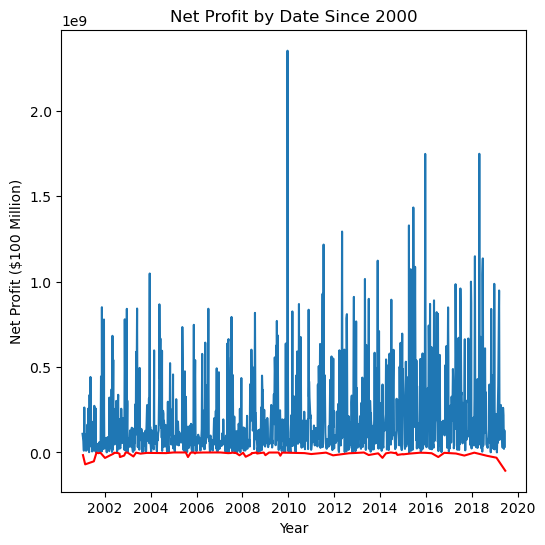

In [511]:
net_gain_by_date = tn_date_profits_sorted_uniq_2000.groupby(['release_date'])['worldwide_net'].sum().reset_index()

# All gains after 2000
net_gain_by_date_gain = net_gain_by_date[net_gain_by_date["worldwide_net"] > 0]

# All losses after 2000
net_gain_by_date_loss = net_gain_by_date[net_gain_by_date["worldwide_net"] <= 0]


plt.figure(figsize=(6, 6))
plt.title("Net Profit by Date Since 2000")
plt.xlabel("Year")
plt.ylabel("Net Profit ($100 Million)")
plt.plot(net_gain_by_date_gain['release_date'],net_gain_by_date_gain['worldwide_net'])
plt.plot(net_gain_by_date_loss['release_date'],net_gain_by_date_loss['worldwide_net'],color = "red")
net_gain_by_date

,month,worldwide_net
0,1,6862887823
1,2,11376234493
2,3,15174216595
3,4,12238451848
4,5,31053107950
5,6,27400622941
6,7,27685310815
7,8,11360601924
8,9,8033827169
9,10,10180793314


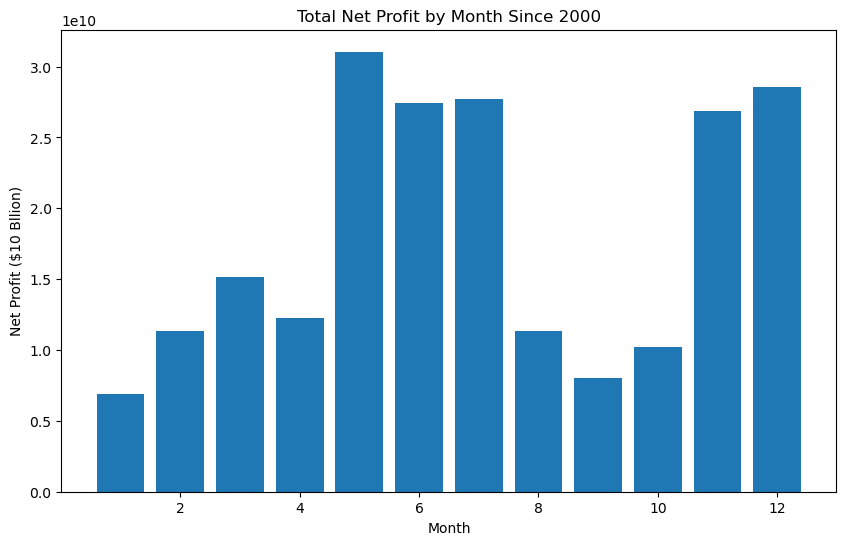

In [512]:
net_gain_by_month = tn_date_profits_sorted_uniq_2000.groupby(['month'])['worldwide_net'].sum().reset_index()

# All gains after 2000
net_gain_by_month_gain = net_gain_by_month[net_gain_by_month["worldwide_net"] > 0]

# All losses after 2000
net_gain_by_month_loss = net_gain_by_month[net_gain_by_month["worldwide_net"] <= 0]

plt.figure(figsize=(10, 6))
plt.title("Total Net Profit by Month Since 2000")
plt.xlabel("Month")
plt.ylabel("Net Profit ($10 Bllion)")
plt.bar(net_gain_by_month_gain['month'],net_gain_by_month_gain['worldwide_net'])
plt.bar(net_gain_by_month_loss['month'],net_gain_by_month_loss['worldwide_net'],color = "red")
net_gain_by_month

,day,worldwide_net
0,1,6437463576
1,2,6468933776
2,3,9070610886
3,4,7237822623
4,5,7520684345
5,6,5735873858
6,7,6199792709
7,8,7457799650
8,9,6171628950
9,10,6669927233


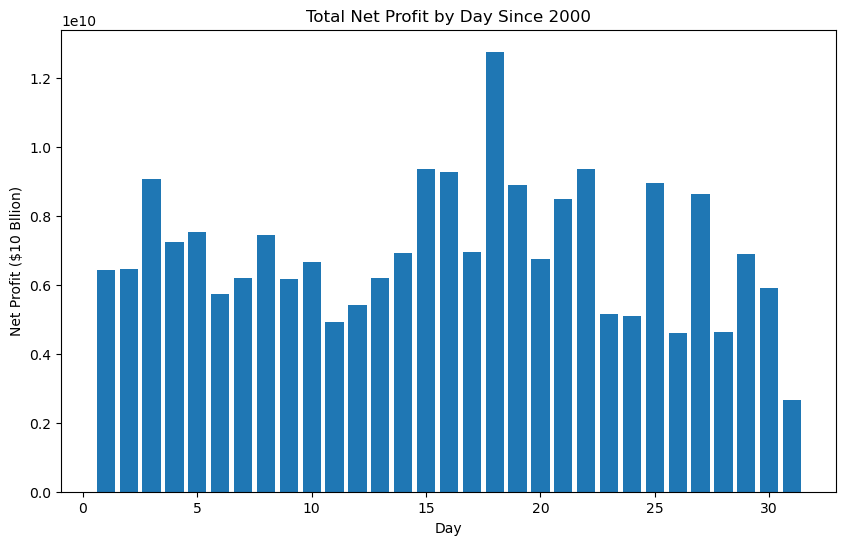

In [513]:
net_gain_by_day = tn_date_profits_sorted_uniq_2000.groupby(['day'])['worldwide_net'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.title("Total Net Profit by Day Since 2000")
plt.xlabel("Day")
plt.ylabel("Net Profit ($10 Bllion)")
plt.bar(net_gain_by_day['day'],net_gain_by_day['worldwide_net'])
net_gain_by_day[:10]

,day_of_week,worldwide_net
0,Friday,174963575909
1,Monday,694377949
2,Saturday,265835485
3,Sunday,321749494
4,Thursday,8602528053
5,Tuesday,2101145101
6,Wednesday,29834963106


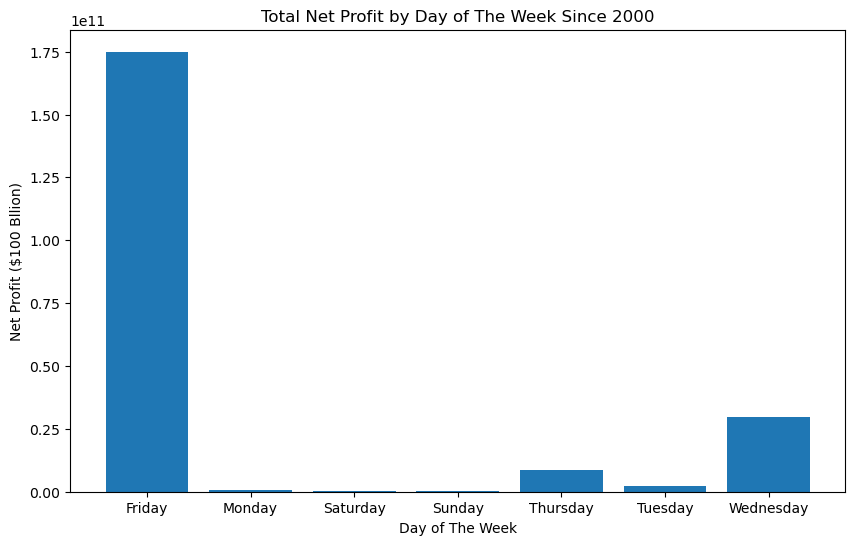

In [514]:
net_gain_by_dayof = tn_date_profits_sorted_uniq_2000.groupby(['day_of_week'])['worldwide_net'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.title("Total Net Profit by Day of The Week Since 2000")
plt.xlabel("Day of The Week")
plt.ylabel("Net Profit ($100 Bllion)")
plt.bar(net_gain_by_dayof['day_of_week'],net_gain_by_dayof['worldwide_net'])
net_gain_by_dayof

# TMDB

Highest rated 


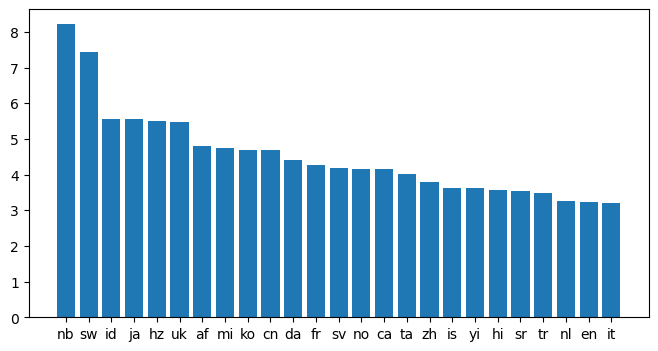

In [515]:
# Average rating by language shows and movies
tmdb_pop_lang = tmdb_df[['popularity',"original_language"]]
tmdb_pop_lang = tmdb_pop_lang.groupby(['original_language'])['popularity'].mean().reset_index()
tmdb_pop_lang = tmdb_pop_lang.sort_values(by= 'popularity', ascending= False)
plt.figure(figsize=(8,4))
plt.bar(tmdb_pop_lang['original_language'][:25],tmdb_pop_lang['popularity'][:25] )
print("Highest rated ")

<BarContainer object of 19 artists>

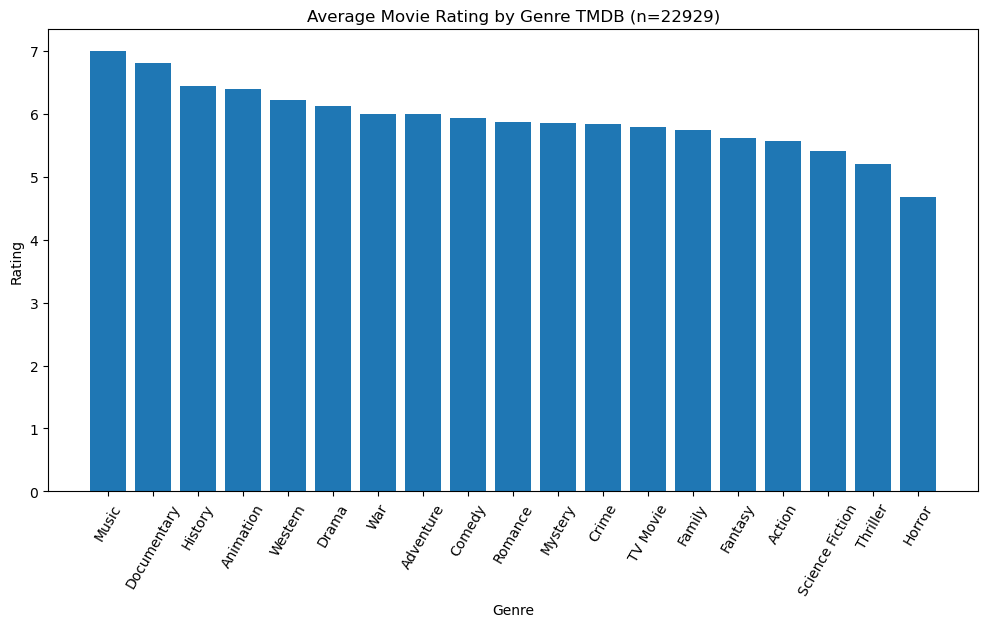

In [516]:
# Average movie rating by genre
tmdb_movie_rating = tmdb_df[['genre_str','vote_average']]
tmdb_movie_rating = tmdb_movie_rating.groupby(['genre_str'])['vote_average'].mean().reset_index()
tmdb_movie_rating = tmdb_movie_rating.sort_values(by='vote_average',ascending=False)

# Add genre count
genre_counts = tmdb_df['genre_str'].value_counts().reset_index()
genre_counts.columns = ['genre_str', 'count']
result = pd.merge(tmdb_movie_rating, genre_counts, on='genre_str')
tmdb_movie_rating['genre_counts'] = result["count"]
tmdb_movie_rating

# Plot
plt.figure(figsize=(12,6))
plt.title('Average Movie Rating by Genre TMDB'+" (n="+str(len(tmdb_df))+")")
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.tick_params(axis='x', labelrotation=60)
plt.bar(tmdb_movie_rating['genre_str'],tmdb_movie_rating['vote_average'] )

<BarContainer object of 19 artists>

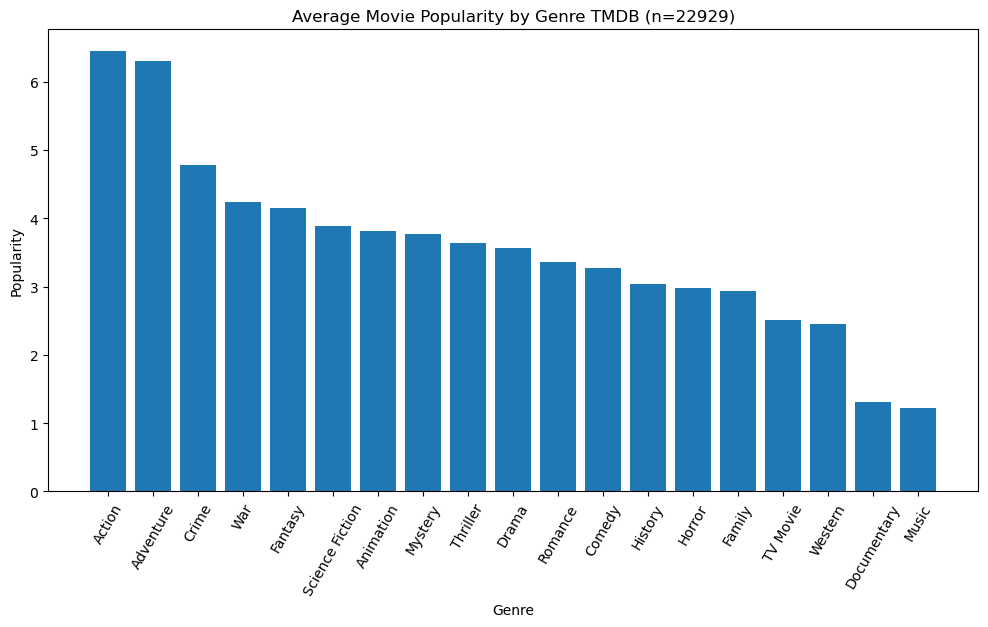

In [517]:
tmdb_pop_genre = tmdb_df[['popularity','genre_str']]
tmdb_pop_genre =  tmdb_pop_genre.groupby(['genre_str'])['popularity'].mean().reset_index()
tmdb_pop_genre = tmdb_pop_genre.sort_values(by='popularity',ascending= False)


plt.figure(figsize=(12,6))
plt.title('Average Movie Popularity by Genre TMDB'+" (n="+str(len(tmdb_df))+")")
plt.xlabel('Genre')
plt.ylabel('Popularity')
plt.tick_params(axis='x', labelrotation=60)
plt.bar(tmdb_pop_genre['genre_str'],tmdb_pop_genre['popularity'])


<BarContainer object of 19 artists>

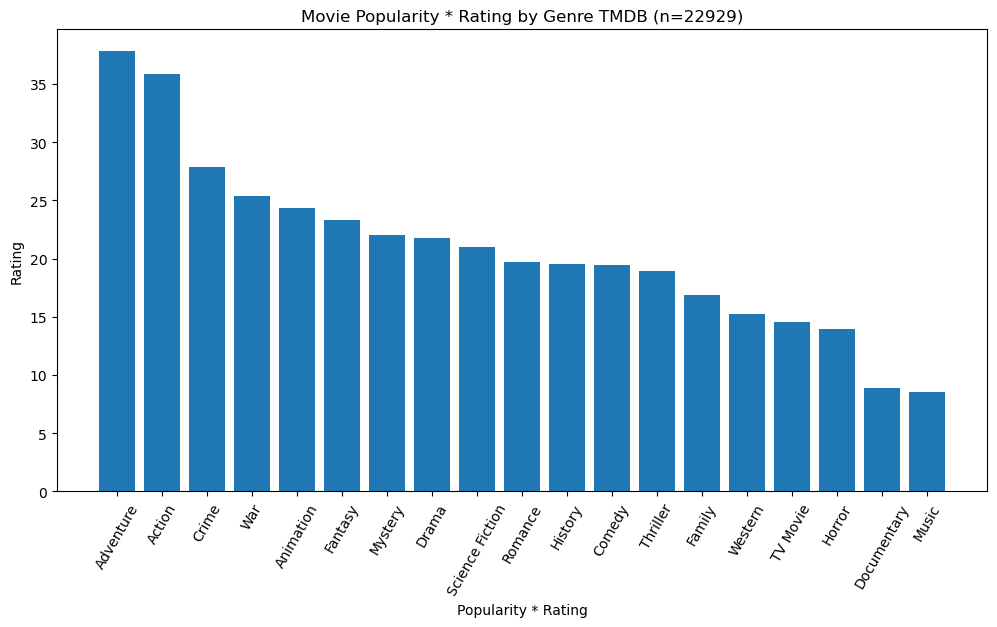

In [518]:
tmdb_pop_rating_prod = pd.merge(tmdb_pop_genre, tmdb_movie_rating, on='genre_str', how='inner')
tmdb_pop_rating_prod['pop*vote'] = tmdb_pop_rating_prod['popularity'] * tmdb_pop_rating_prod['vote_average']
tmdb_pop_rating_prod = tmdb_pop_rating_prod.sort_values(by='pop*vote',ascending= False)
plt.figure(figsize=(12,6))
plt.title('Movie Popularity * Rating by Genre TMDB'+" (n="+str(len(tmdb_df))+")")
plt.xlabel('Popularity * Rating')
plt.ylabel('Rating')
plt.tick_params(axis='x', labelrotation=60)
plt.bar(tmdb_pop_rating_prod['genre_str'],tmdb_pop_rating_prod['pop*vote'])

## IMDB

### IMDB Movie Rating Analysis

We will want to investigate the range of the number of votes cast for each film to determine what a meaningful number of votes cast would be.

If we compare a film has a 10.0 rating with 5 votes cast to a film that has a 9.5 rating with 5000 votes cast, we trust the later number more. 

In [519]:
# Calculate statistics
min_votes = imdb_movie_rating_df['numvotes'].min()
max_votes = imdb_movie_rating_df['numvotes'].max()
mean_votes = imdb_movie_rating_df['numvotes'].mean()
median_votes = imdb_movie_rating_df['numvotes'].median()

print(f"Minimum number of votes: {min_votes}")
print(f"Maximum number of votes: {max_votes}")
print(f"Mean number of votes: {mean_votes}")
print(f"Median number of votes: {median_votes}")

Minimum number of votes: 5.0
Maximum number of votes: 1841066.0
Mean number of votes: 8405.710850153822
Median number of votes: 65.0


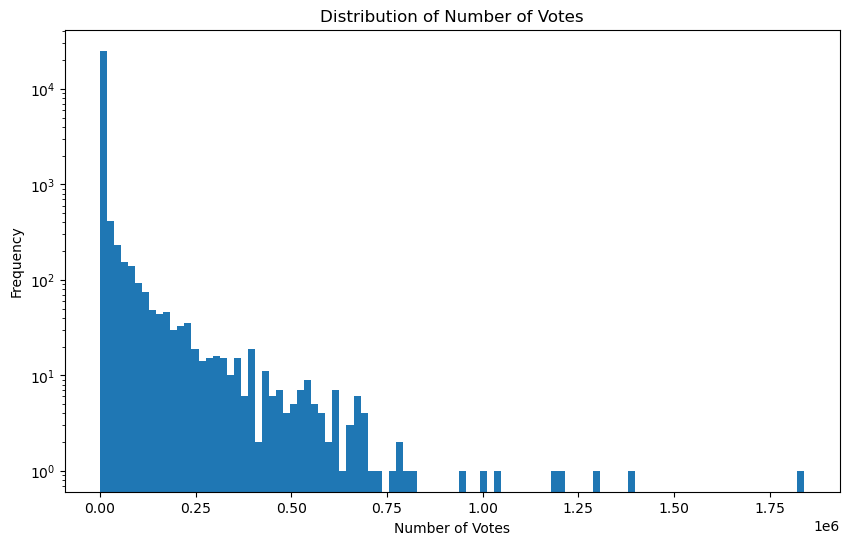

In [520]:
# View the distribution of votes
plt.figure(figsize=(10,6))

# Using log scale due to the wide range of values
plt.hist(imdb_movie_rating_df['numvotes'], bins=100, log=True)

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Votes')
plt.show()

Since the distribution of votes is not normal distributed and it is heavily skewed to the right, we should use percentiles to determine which number of votes is signficant. 

Percentiles help us understand the spread and central tendency of the data without being overly influenced by extreme values.

They allow us to set thresholds based on the data's distribution. Using the 75th percentile means we are focusing on the top 25% of films by the number of votes, which likely represent more significant, widely-reviewed films.

This measure is more meaningful than using an arbitrary threshold because it is tailored to the data's distribution.

In [521]:
# Calculate the 75th and 90th percentiles
percentile_75 = imdb_movie_rating_df['numvotes'].quantile(0.75)
percentile_90 = imdb_movie_rating_df['numvotes'].quantile(0.90)

print(f"75th percentile of votes: {percentile_75}")
print(f"90th percentile of votes: {percentile_90}")

75th percentile of votes: 526.75
90th percentile of votes: 5445.600000000006


To be more inclusive we will be using the 75th percentile moving forward.

In [522]:
# Set the threshold using the 75th percentile
threshold = percentile_75

# Filter the DataFrame to include only movies with numvotes at or above the threshold
imdb_significant_movie_votes_df = imdb_movie_rating_df[imdb_movie_rating_df['numvotes'] >= threshold]

In [523]:
# Split genres column by commas for genre classification
imdb_significant_movie_votes_df['high_level_classification'] = imdb_significant_movie_votes_df['genres'].apply(lambda x: x.split(',')[0])
imdb_significant_movie_votes_df['further_classification'] = imdb_significant_movie_votes_df['genres'].apply(lambda x: ','.join(x.split(',')[1:]) if ',' in x else None)

In [524]:
# Group by and aggregate to see which genres perform the best
genre_rating_df = imdb_significant_movie_votes_df.groupby('high_level_classification').agg(
    average_rating=('averagerating', 'mean'),
    numvotes=('numvotes', 'mean'),
    movie_count=('high_level_classification', 'size')
).reset_index()

# Sort the new DataFrame
genre_rating_df = genre_rating_df.sort_values(by='average_rating', ascending= False)

genre_rating_df

,high_level_classification,average_rating,numvotes,movie_count
21,unknown,7.250000,1020.500000,2
12,Music,7.233333,5992.333333,3
6,Documentary,7.058300,3380.370445,494
3,Biography,6.966425,35684.852657,414
2,Animation,6.412069,23633.879310,58
1,Adventure,6.243467,68131.053333,375
7,Drama,6.119701,23144.255224,1340
10,History,6.100000,560.000000,1
5,Crime,5.987042,30769.994366,355
15,Romance,5.962069,10220.413793,29


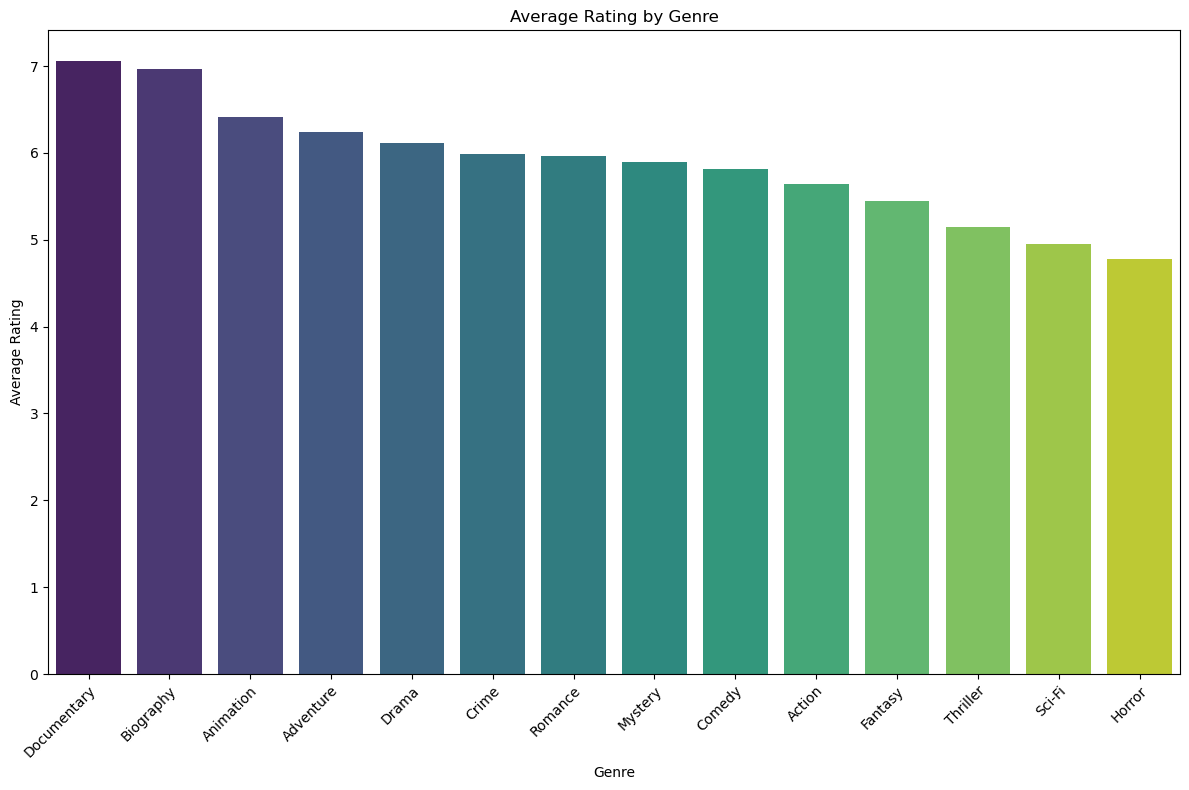

In [525]:
# Filter out genres that have less than 15 counts
genre_rating_df = genre_rating_df[genre_rating_df['movie_count'] > 15]


# Plotting the graph
plt.figure(figsize=(12, 8))
sns.barplot(x='high_level_classification', y='average_rating', data=genre_rating_df, palette='viridis')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show();

### IMDB Cast Analysis

In [526]:
imdb_cast_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230583 entries, 0 to 388621
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         230583 non-null  object 
 1   title            230583 non-null  object 
 2   year             230583 non-null  int64  
 3   runtime_minutes  230583 non-null  object 
 4   genres           230583 non-null  object 
 5   cast_category    230583 non-null  object 
 6   cast_name        230583 non-null  object 
 7   averagerating    230583 non-null  float64
 8   numvotes         230583 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 17.6+ MB


In [527]:
# Calculate the 75th and 90th percentiles
percentile_75 = imdb_cast_info_df['numvotes'].quantile(0.75)

# Set the threshold using the 75th percentile
threshold = percentile_75

# Filter the DataFrame to include only movies with numvotes at or above the threshold
imdb_cast_info_df = imdb_cast_info_df[imdb_cast_info_df['numvotes'] >= threshold]

imdb_cast_info_df.info()

#### Directors

In [528]:
# Filter to see the directors only
imdb_director_df = imdb_cast_info_df[imdb_cast_info_df['cast_category'] == 'director']

In [529]:
# Group by and aggregate to see which directors perform the best
director_stats_df = imdb_director_df.groupby('cast_name').agg(
    average_rating=('averagerating', 'mean'),
    average_numvotes=('numvotes', 'mean'),
    movie_count=('movie_id', 'count')
).reset_index()

# Sort the DataFrame
director_stats_df = director_stats_df.sort_values(by='average_rating', ascending= False)

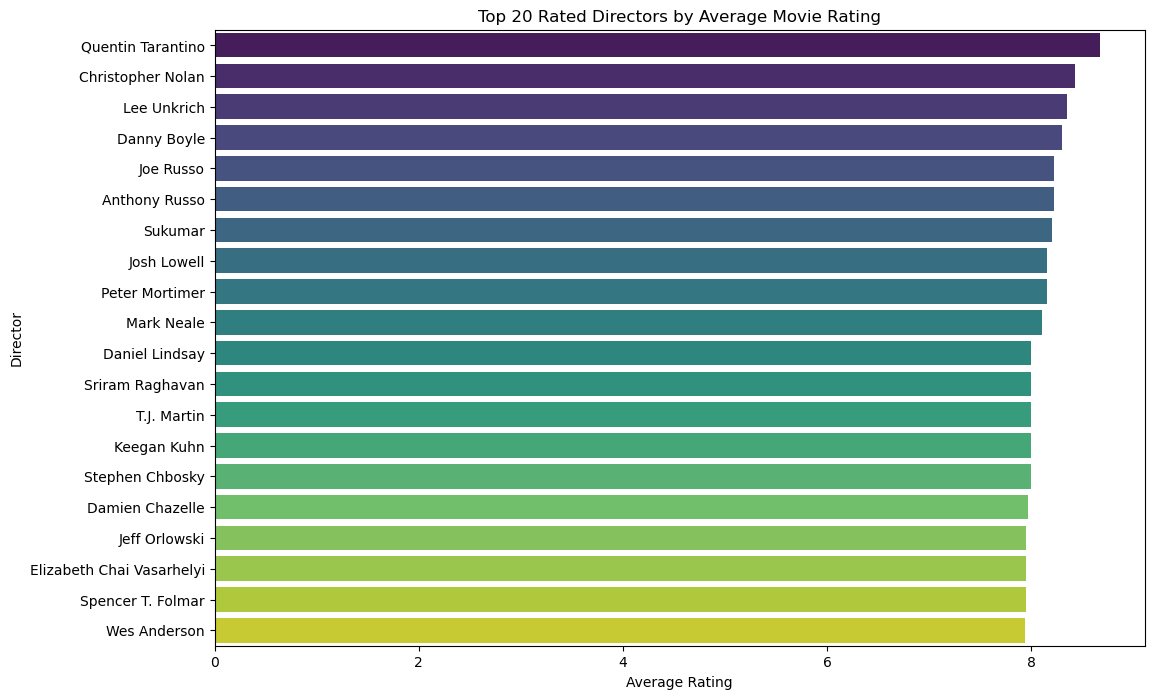

In [530]:
# Filter to see the top 20 directors by average rating
top_20_directors_df = director_stats_df[director_stats_df['movie_count'] > 1].head(20)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    x='average_rating', 
    y='cast_name', 
    data=top_20_directors_df, 
    palette='viridis'
)
plt.xlabel('Average Rating')
plt.ylabel('Director')
plt.title('Top 20 Rated Directors by Average Movie Rating')
plt.show()

#### Actors

In [531]:
# Filter to see only actors and actresses
imdb_actor_actress_df = imdb_cast_info_df[imdb_cast_info_df['cast_category'].isin(['actor', 'actress'])]

In [532]:
# Group by and aggregate to see which directors perform the best
actor_actress_stats_df = imdb_actor_actress_df.groupby('cast_name').agg(
    average_rating=('averagerating', 'mean'),
    average_numvotes=('numvotes', 'mean'),
    movie_count=('movie_id', 'count')
).reset_index()

# Sort the DataFrame
actor_actress_stats_df = actor_actress_stats_df.sort_values(by='average_rating', ascending= False)

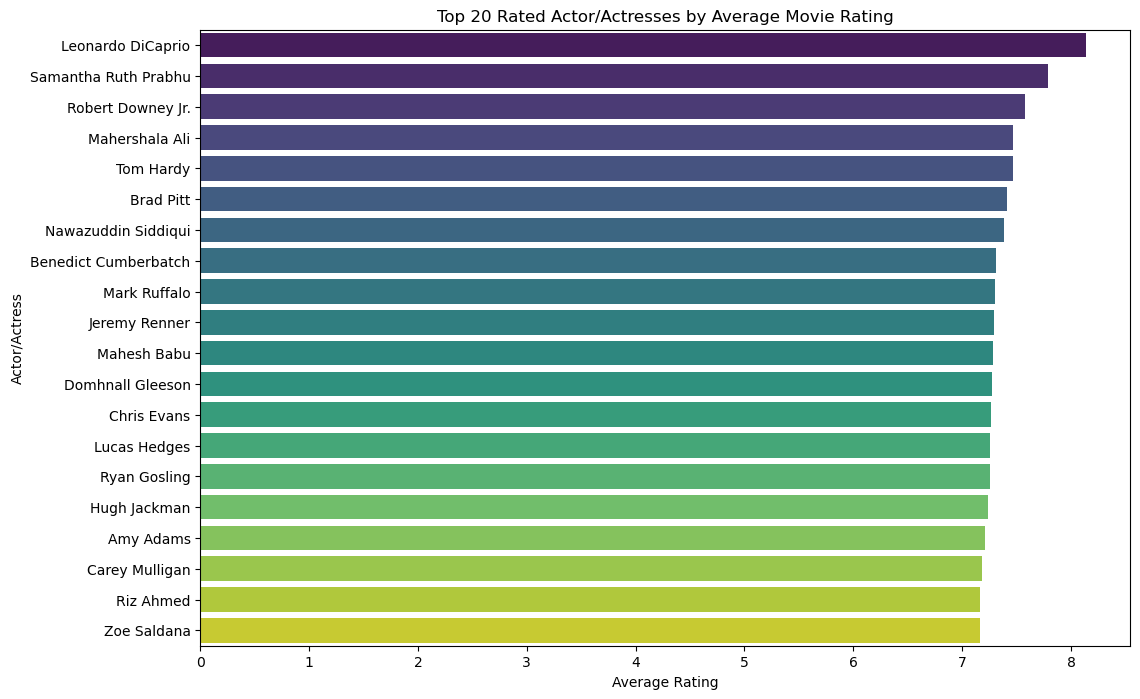

In [533]:
# Filter to see the top 20 directors by average rating
top_20_actor_actress_df = actor_actress_stats_df[actor_actress_stats_df['movie_count'] >= 5].head(20)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    x='average_rating', 
    y='cast_name', 
    data=top_20_actor_actress_df, 
    palette='viridis'
)
plt.xlabel('Average Rating')
plt.ylabel('Actor/Actress')
plt.title('Top 20 Rated Actor/Actresses by Average Movie Rating')
plt.show()

## RT

In [534]:
def rt_get_top_20(dataframe, column):
    # Drop rows with NaNs
    new_dataframe = dataframe.dropna(subset=[column])

    # Print number of rows in DataFrame
    print(f"Number of Rows: {len(new_dataframe)}")
    
    # Group and aggregate by specified column
    new_dataframe = new_dataframe.groupby(column).agg(
    average_rating = ('rating_review', 'mean')
    ,review_count = (column, 'size')
    ).reset_index()

    # Sort DataFrame
    new_dataframe = new_dataframe.sort_values(by='average_rating', ascending=False)
    
    # Filter to see the top 20 of the specified column by average rating
    top_20_dataframe = new_dataframe.head(20)
    
    return top_20_dataframe

In [535]:
def rt_plot_graph(dataframe, column):
    # Format column title for the graph label
    split_column = column.split('_')
    plural_column = " ".join(split_column) + "s"
    formatted_column = plural_column.title()
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='average_rating', 
        y=column, 
        data=dataframe, 
        palette='colorblind'
    )
    plt.xlabel('Average Rating')
    plt.ylabel(formatted_column)
    plt.title(f'Top 20 {formatted_column} by Average Movie Rating')
    plt.show()

### Directors

In [536]:
top_20_director_df = rt_get_top_20(rt_combined_df, 'director')


Number of Rows: 5844


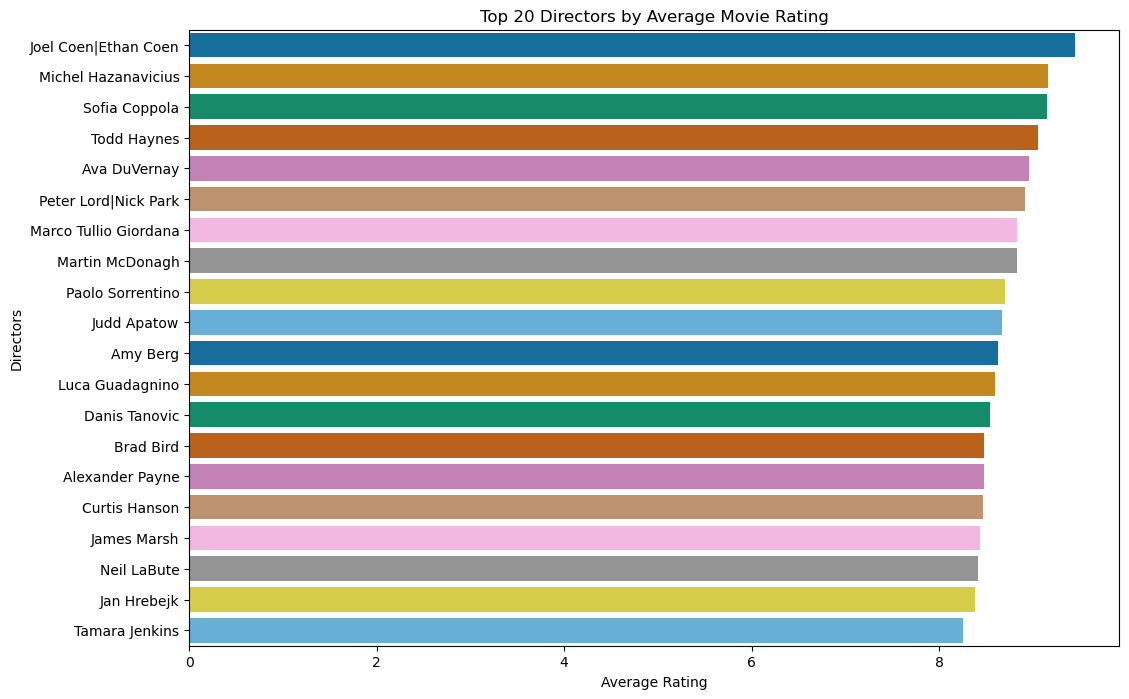

In [537]:
rt_plot_graph(top_20_director_df, 'director')

### Writers

In [538]:
top_20_writer_df = rt_get_top_20(rt_combined_df, 'writer')


Number of Rows: 5445


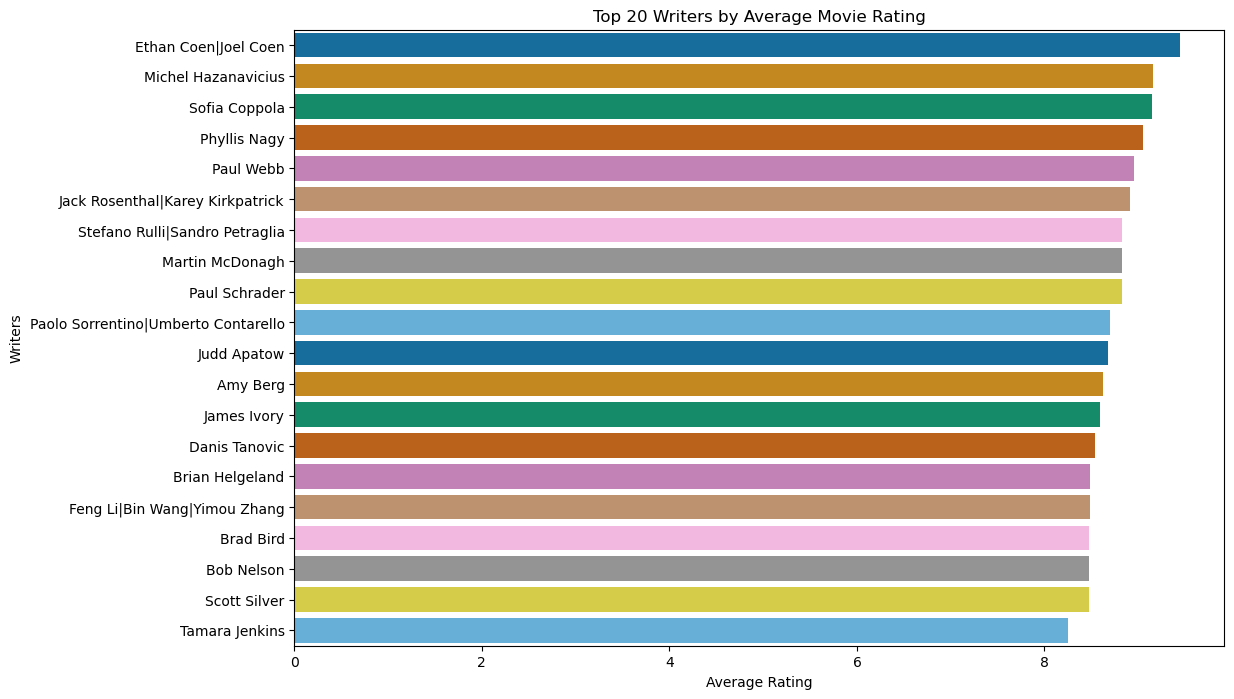

In [539]:
rt_plot_graph(top_20_writer_df, 'writer')

### Studio

In [540]:
top_20_studio_df = rt_get_top_20(rt_combined_df, 'studio')


Number of Rows: 6030


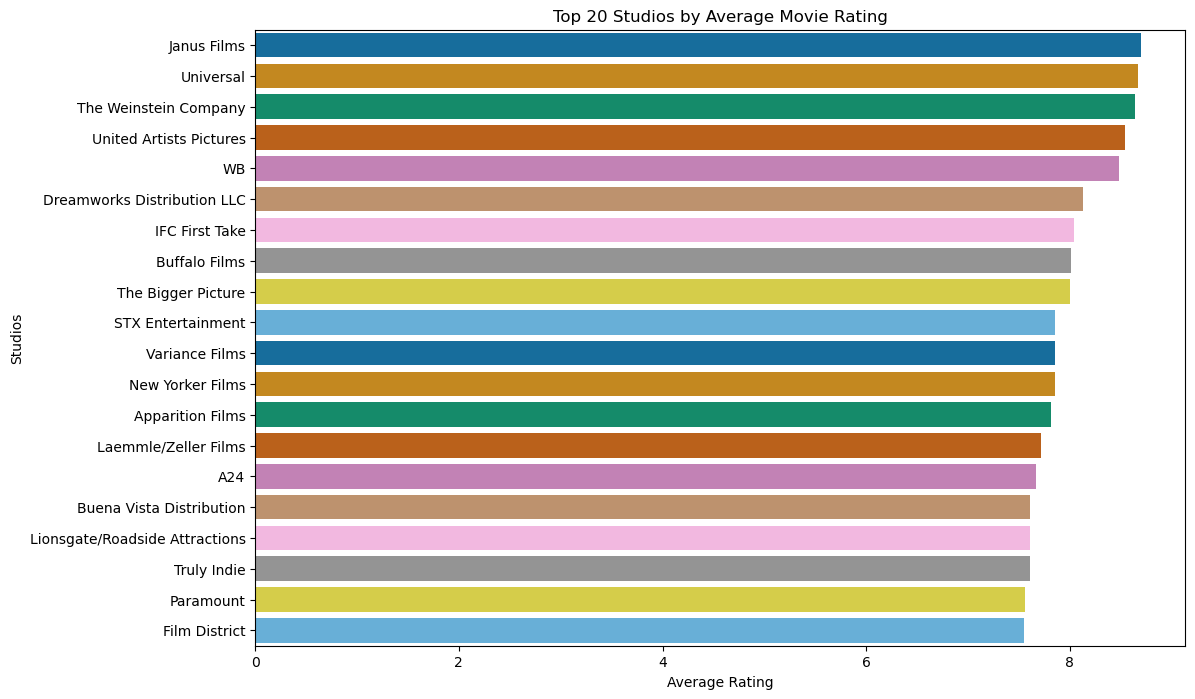

In [541]:
rt_plot_graph(top_20_studio_df, 'studio')

### Runtime

In [542]:
top_20_runtime_df = rt_get_top_20(rt_combined_df, 'runtime')


Number of Rows: 6550


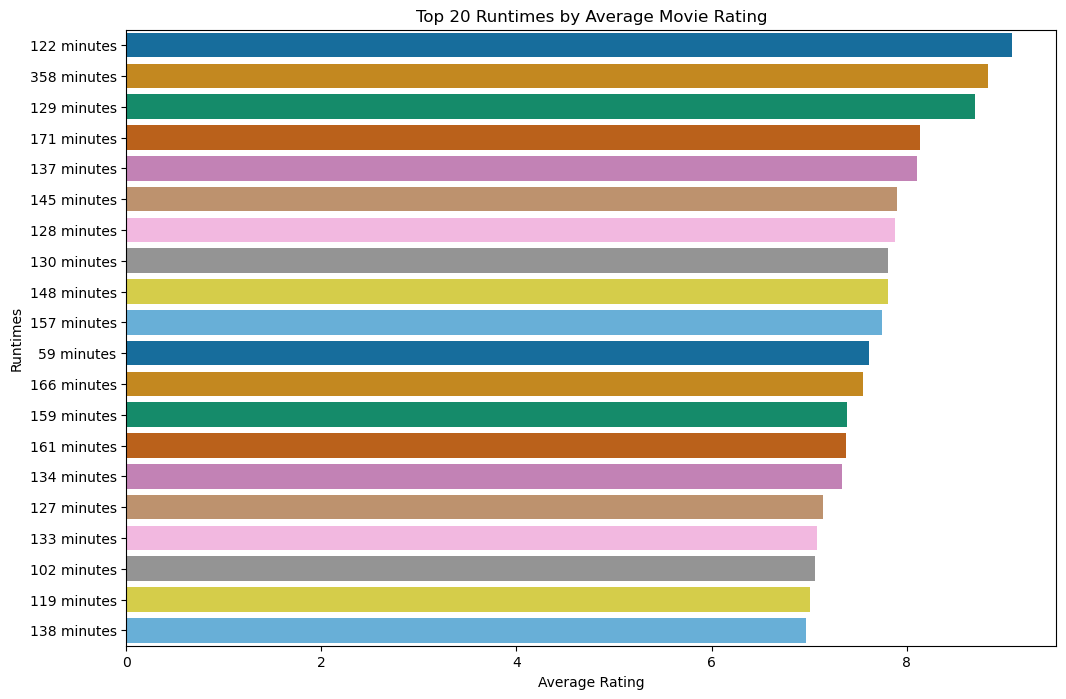

In [543]:
rt_plot_graph(top_20_runtime_df, 'runtime')

### Genre

In [544]:
# Filter DataFrame
rt_genre_df = rt_combined_df[['rating_info', 'genre', 'director', 'box_office', 'studio', 'rating_review', 'fresh']]

# Split the 'genre' column by the pipe delimiter
rt_genre_df[['main_genre', 'sub_genre']] = rt_genre_df['genre'].str.split('|', n=1, expand=True)

# Print number of rows in DataFrame
print(f"Number of Rows: {len(rt_genre_df)}")

Number of Rows: 6626


In [545]:
# Group and aggregate by specified column
rt_genre_df = rt_genre_df.groupby('main_genre').agg(
average_rating = ('rating_review', 'mean')
,review_count = ('main_genre', 'size')
).reset_index()

# Sort DataFrame
rt_genre_df = rt_genre_df.sort_values(by='average_rating', ascending=False)

# Filter to see the top 20 of the specified column by average rating
top_20_genre_dataframe = rt_genre_df.head(20)

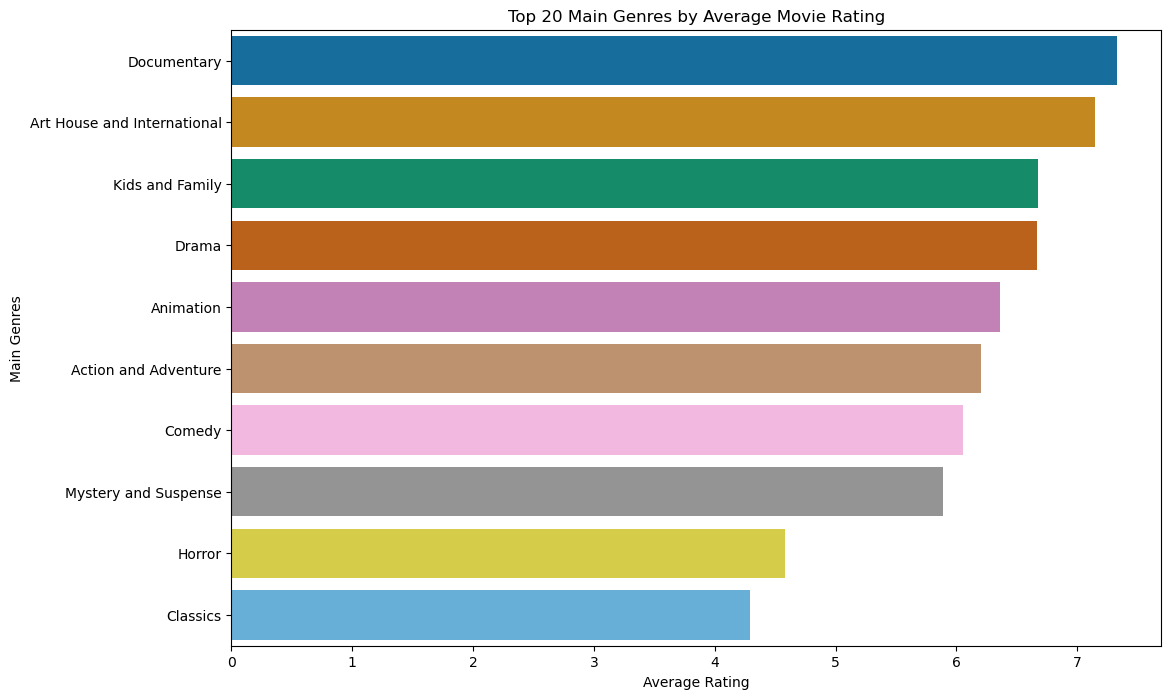

In [546]:
rt_plot_graph(top_20_genre_dataframe, 'main_genre')

### Rating

In [547]:
# Filter DataFrame
rt_rating_df = rt_combined_df[['rating_info', 'genre', 'director', 'box_office', 'studio', 'rating_review', 'fresh']]

# Group and aggregate by specified column
rt_rating_df = rt_rating_df.groupby('rating_info').agg(
average_rating = ('rating_review', 'mean')
,review_count = ('rating_info', 'size')
).reset_index()

# Sort DataFrame
rt_rating_df = rt_rating_df.sort_values(by='average_rating', ascending=False)

# Filter to see the top 20 of the specified column by average rating
top_20_rating_df = rt_rating_df.head(20)

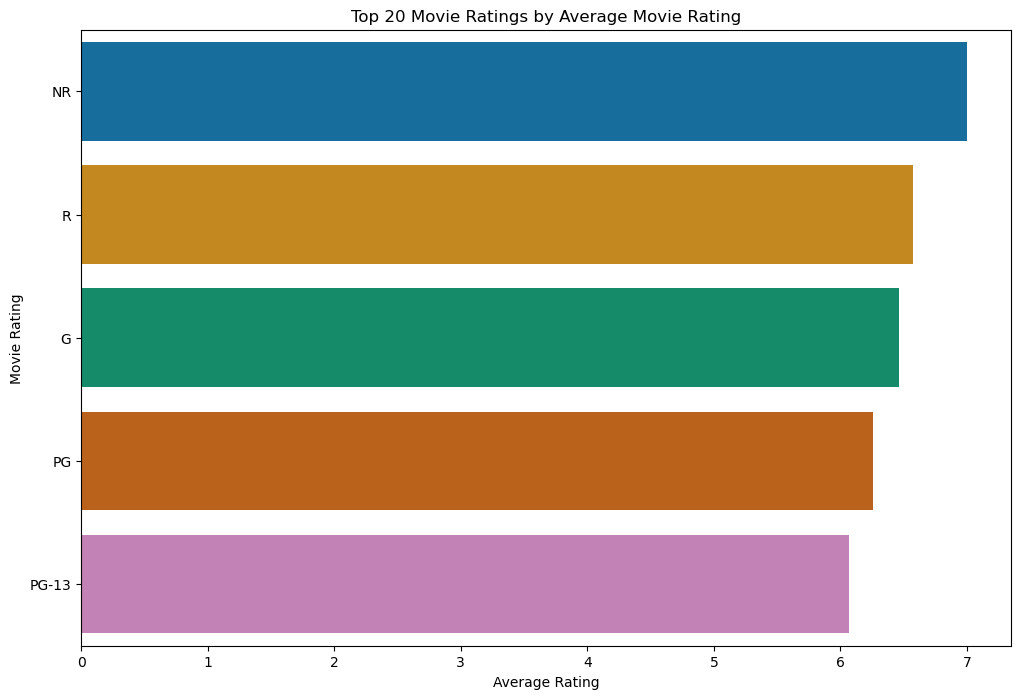

In [548]:
# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    x='average_rating', 
    y='rating_info', 
    data=top_20_rating_df, 
    palette='colorblind'
)
plt.xlabel('Average Rating')
plt.ylabel('Movie Rating')
plt.title('Top 20 Movie Ratings by Average Movie Rating')
plt.show()